# Investigating the Boston House Prices Dataset
Machine Learning and Statistics Project 2019

## Introduction

Getting Started
In this project, I will be looking at the well known Boston House Prices Dataset. It will include a look into the data and some general stats, and then we will be attempting to use keras to create a neural network
that can predict the median house price based on the other variables in the dataset In this dataset infomation was collected from homes in suburbs of Boston, Massachusetts. This model could be very helpful for someone like a real estate agent city planners who could make use of such information on a daily basis.

The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts.[5]

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

Next load data from scikit-learn lib and have a look at data

In [66]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


These are essentially keys to a dictionary

- data: info for different houses
- target: prices for different houses
- feature_names: names of the features
- DESCR: describes the dataset

In [67]:
print(boston.data.shape)

(506, 13)


Check for its shape by calling the boston.data.shape and it will return the size of the dataset with the column size.
This means there are 506 rows of data with 13 columns. What are the 13 columns. 

In [68]:
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


These are the column names but they don't make too much sense we need some more info

In [69]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

So as we can see there are quite a few variables listed that could have an effect on house prices such as crime rate, number of rooms, pupil teacher ratio. There are a few that may not quite affect house prices so we may eliminate these initally so make things a bit more understandable.
- ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS    proportion of non-retail business acres per town
- AGE      proportion of owner-occupied units built prior to 1940
***
So now we know a little more about this lets have a look using pandas at the actual data. To do this we have to convert it to dataframe and use head() to have a look

In [70]:
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df = df.drop("ZN", 1)
df = df.drop("INDUS", 1)
df = df.drop("AGE", 1)
# need to add column names otherwise we just get index numbers which aren't very helpful alone
display(df.head())

,CRIM,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,0.0,0.538,6.575,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,0.469,6.421,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,0.469,7.185,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,0.458,6.998,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,0.458,7.147,6.0622,3.0,222.0,18.7,396.90,5.33


There seems to be no column called price in the df? The target column it’s available in another attribute called target as we saw above when we looked at our keys. This is an important variable as later we will be trying to predict this. Our target is MEDV which is the median house value in 1000's of dollars. we need to check the shape of boston.target

In [71]:
print(boston.target.shape)
# rows see above data keys

(506,)


this matches our datasets number of rows as we saw above so we can add it to our df

In [72]:
# changed medv to price for readablity
df['PRICE'] = boston['target']
# used display to make nice table [1]
display(df.head())

,CRIM,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,0.0,0.538,6.575,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,0.469,6.421,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,0.469,7.185,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,0.458,6.998,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,0.458,7.147,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [73]:
# moved price to front of df for ease
# dummy var to hold copy of proce column
y = df['PRICE'].copy()
# delete it from frame
del df['PRICE']
# concentate to combine it with reaining df along 1st axis [2]
df = pd.concat((y, df), axis=1)


In [74]:
df.head()

,PRICE,CRIM,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,0.0,0.538,6.575,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,0.469,6.421,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,0.469,7.185,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,0.458,6.998,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,0.458,7.147,6.0622,3.0,222.0,18.7,396.90,5.33


In [75]:
df.tail()
# zn and chas have alot of 0s

,PRICE,CRIM,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT
501,22.4,0.06263,0.0,0.573,6.593,2.4786,1.0,273.0,21.0,391.99,9.67
502,20.6,0.04527,0.0,0.573,6.120,2.2875,1.0,273.0,21.0,396.90,9.08
503,23.9,0.06076,0.0,0.573,6.976,2.1675,1.0,273.0,21.0,396.90,5.64
504,22.0,0.10959,0.0,0.573,6.794,2.3889,1.0,273.0,21.0,393.45,6.48
505,11.9,0.04741,0.0,0.573,6.030,2.5050,1.0,273.0,21.0,396.90,7.88


In [76]:
df.isnull().sum()
#checking for any missing data 
#which Pandas automatically sets as NaN values.we can see these by using df.isnull() , 
#and then the number of NaN's per column is df.isnull().sum()

PRICE      0
CRIM       0
CHAS       0
NOX        0
RM         0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [77]:
#replaced all the 0s with nan [4]
#df.replace(0, np.nan, inplace=True)
#df.info()

In [78]:
#getting percentage will disregard zn and chas
#df.isnull().sum()/len(df)*100

In [79]:
#df = df.drop("ZN", 1)
#df = df.drop("CHAS", 1) # charles river variable will need later!

In [80]:
len(df)

506

In [81]:
df.dtypes

PRICE      float64
CRIM       float64
CHAS       float64
NOX        float64
RM         float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

All data are floats, which means this is most likely a continuous variable, including the target. This means that predicting the target variable is a regression problem. [3]

In [82]:
display(df.describe().T)
# transposed data to make it easier to read

,count,mean,std,min,25%,50%,75%,max
PRICE,506.0,22.532806,9.197104,5.00000,17.025000,21.20000,25.000000,50.0000
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000
PTRATIO,506.0,18.455534,2.164946,12.60000,17.400000,19.05000,20.200000,22.0000
B,506.0,356.674032,91.294864,0.32000,375.377500,391.44000,396.225000,396.9000


We have data from 506 neighborhoods/townships in the Boston area. Summary of some tendencies and distribution of some key features:

- The average per capita crime rate is 3.61%
- The average number of rooms per dweling is 6.28, but ranges from 3.5 to 8.7.
- The average nitic oxide concentration (in parts per 10 million) is .55. The neighborhood with the least NOX has .38, the one with the most has .87.
- The average Pupil-Teacher ratio is 18 students to one teacher.
- The average weighted distance to the five major Boston employment centers is 3.79.
- The average percent of lower status population is 12.65%, but ranges from 1.73% to a more impovrished 37.97%

## Visualising the Data
 In this section, we will use some visualizations to understand the relationship of the target variable with other features.

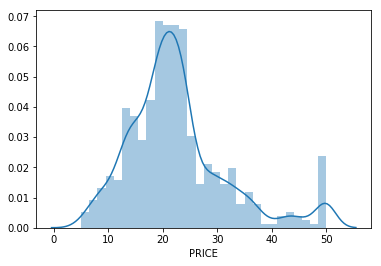

In [83]:
sns.distplot(df['PRICE'], bins=30)
plt.show()

Distribution of Price Variable. We see that the values of price are distributed normally with few outliers.

In [84]:
correlation = df.corr().round(2)
display(correlation)
# annot = True to print the values inside the square
#sns.heatmap(data=correlation, annot=True)
# need to get rid of some columns!!

,PRICE,CRIM,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT
PRICE,1.00,-0.39,0.18,-0.43,0.70,0.25,-0.38,-0.47,-0.51,0.33,-0.74
CRIM,-0.39,1.00,-0.06,0.42,-0.22,-0.38,0.63,0.58,0.29,-0.39,0.46
CHAS,0.18,-0.06,1.00,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05
NOX,-0.43,0.42,0.09,1.00,-0.30,-0.77,0.61,0.67,0.19,-0.38,0.59
RM,0.70,-0.22,0.09,-0.30,1.00,0.21,-0.21,-0.29,-0.36,0.13,-0.61
DIS,0.25,-0.38,-0.10,-0.77,0.21,1.00,-0.49,-0.53,-0.23,0.29,-0.50
RAD,-0.38,0.63,-0.01,0.61,-0.21,-0.49,1.00,0.91,0.46,-0.44,0.49
TAX,-0.47,0.58,-0.04,0.67,-0.29,-0.53,0.91,1.00,0.46,-0.44,0.54
PTRATIO,-0.51,0.29,-0.12,0.19,-0.36,-0.23,0.46,0.46,1.00,-0.18,0.37
B,0.33,-0.39,0.05,-0.38,0.13,0.29,-0.44,-0.44,-0.18,1.00,-0.37


This resulting table shows the correlation score between each set of values. Large positive scores indicate a strong positive (that is, in the same direction) correlation.As expected, we see maximum values of 1 on the diagonal.

## Scatter Plots to look for linear relationships
stronger predictors will have small, tight distribution of data around the line of best fit estimated by the plot.

Text(0.5, 1.0, 'Relationship between RM and Price')

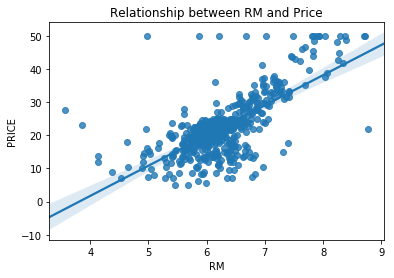

In [85]:
sns.regplot(y="PRICE", x="RM", data=df, fit_reg = True)
plt.title("Relationship between RM and Price")

no of rooms seems to have strong positive coorelation the prices increase as the value of RM increases linearly. There are few outliers and the data seems to be capped at 50.

Text(0.5, 1.0, 'Relationship between LSTAT and Price')

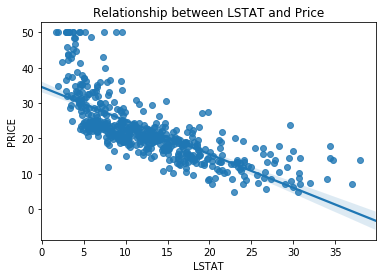

In [86]:
sns.regplot(y="PRICE", x="LSTAT", data=df, fit_reg = True)
plt.title("Relationship between LSTAT and Price")

% of Lower Status Population
Strong negative coorelation. The prices tend to decrease with an increase in lower status individuals. Though it doesn’t look to be following exactly a linear line.

Text(0.5, 1.0, 'Relationship between NOX and Price')

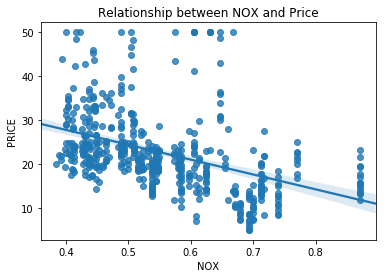

In [87]:
sns.regplot(y="PRICE", x="NOX", data=df, fit_reg = True)
plt.title("Relationship between NOX and Price")

Nitrus Oxide Concentration (in parts per 10 million) strong negative coorelation, prices seems to decresase the more nox there is 

Text(0.5, 1.0, 'Relationship between DIS and Price')

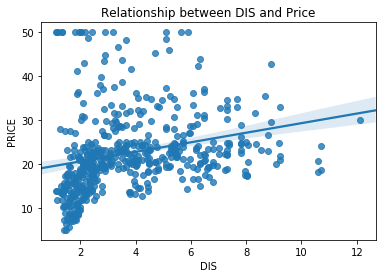

In [88]:
sns.regplot(y="PRICE", x="DIS", data=df, fit_reg = True)
plt.title("Relationship between DIS and Price")

Weighted Distance from 5 Major Employment Centerstrong positive coorelation, the closer the burrogh is to employment centers, the higher the housing price.

Weaker (still decent) Possible Predictors:

Text(0.5, 1.0, 'Relationship between PTRATIO and Price')

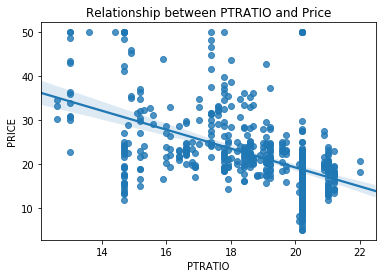

In [89]:
sns.regplot(y="PRICE", x="PTRATIO", data=df, fit_reg = True)
plt.title("Relationship between PTRATIO and Price")

Pupil Teacher Ratio
As the number of students increases for every teacher, the value of housing decreases.

Text(0.5, 1.0, 'Relationship between Crime Rate and Price')

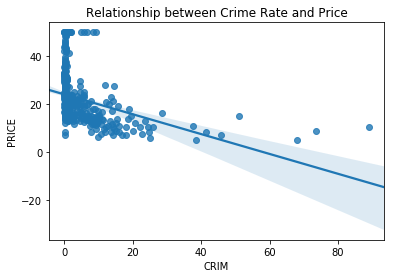

In [90]:
sns.regplot(y="PRICE", x="CRIM", data=df, fit_reg = True)
plt.title("Relationship between Crime Rate and Price")

Crime Rate
As them crime rate decreases/increases, the housing price increases/decreases.

Text(0.5, 1.0, 'Relationship between River and Price')

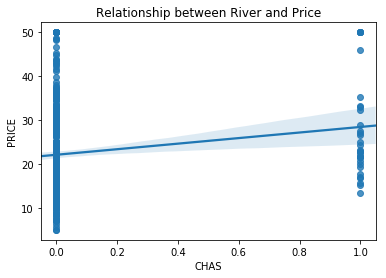

In [91]:
sns.regplot(y="PRICE", x="CHAS", data=df, fit_reg = True)
plt.title("Relationship between River and Price")

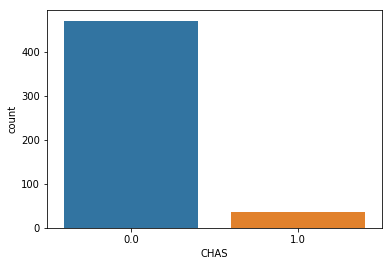

In [92]:
sns.countplot(x='CHAS', data=df)

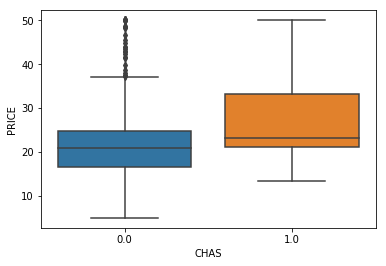

In [93]:
sns.boxplot(x='CHAS',y='PRICE',data=df)